In [75]:
#importing necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import categorical_crossentropy
import tensorflow as tf
#from tensorflow.keras.optimizers import SGD
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam


### Data loading and EDA

In [78]:
# set the train dataset path
train_path = os.getcwd() + '/' + 'dataset/train/' 
# set the test dataset path
test_path = os.getcwd() + '/' + 'dataset/test/'

In [79]:
# array of name of the dataset subfolder
data_folder = ['apple', 'cabbage', 'carrot', 'cucumber', 'eggplant', 'pear', 'zucchini']

In [80]:
def load_label_and_image(data_path, data_folder): 
  X = []
  y = []
  i = 0
  for index, d_folder in enumerate(data_folder): 
    for img_name in os.listdir(data_path + d_folder + '/'):
      i = i +1
      # loads an image from the specified location
      img = cv2.imread(data_path + d_folder + '/' + img_name)
      if img is not None: 
        # convert an image color
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # create AN IMAGE FROM AN array object
        img_array = Image.fromarray(img, 'RGB')
        # resize image to 227x227 which is the required input size of the Alexnet model
        img_rs = img_array.resize((227,227))
        # convert the image to array
        img_rs = np.array(img_rs)

        X.append(img_rs)
        y.append(index)
  return X, y

In [81]:
#load training set
X_train, y_train = load_label_and_image(train_path, data_folder)
#load test set
X_test, y_test = load_label_and_image(test_path, data_folder)

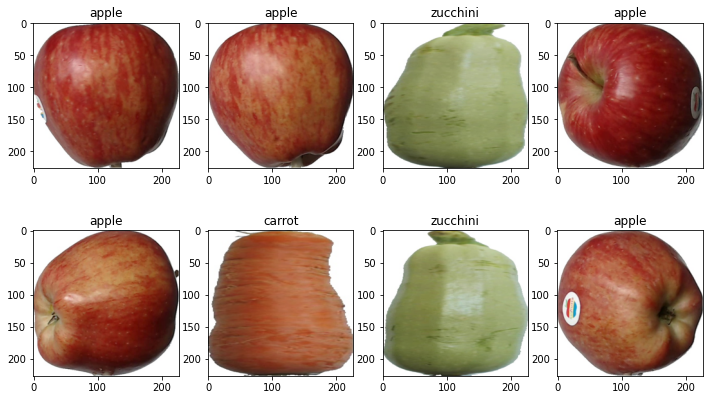

In [83]:
# plot the images
plt.figure(figsize = (12,7))

for i in range(8):
  # for random image pick
  ind = random.randint(0, len(X_train))
  plt.subplot(240 + 1 + i)
  plt.imshow(X_train[ind])
  plt.title(data_folder[y_train[ind]])

###  Define the Alexnet model

In [76]:
def Alexnet():
  # Initialize the model
  model = Sequential()

  # layer 1: convolutional layer + max-pooling layer
  model.add(Conv2D(filters = 96, kernel_size = (11,11), strides= 4, padding = 'valid', activation='relu', input_shape = (227,227,3)))
  model.add(MaxPooling2D(pool_size = (3,3), strides = 2))

  # layer 2: convolutional layer + max-pooling layer 
  model.add(Conv2D(filters = 256, kernel_size = (5,5), padding = 'same', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (3,3), strides = 2))

  # layers 3-5: three convolutional layers + 1 max-pooling layer
  model.add(Conv2D(filters = 384, kernel_size = (3,3), padding = 'same', activation = 'relu'))
  model.add(Conv2D(filters = 384, kernel_size = (3,3), padding = 'same', activation = 'relu'))
  model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (3,3), strides = 2))

  # layers 6 - 8: two fully connected hidden layers and one fully connected output layer
  model.add(Flatten())
  model.add(Dense(4096, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4096, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(7, activation = 'softmax'))

  # compile the model with a loss funciton, a metric and and optimizer method for estimating the loss function
  opt = Adam(lr=0.001)
  #opt = SGD(lr = 0.1)
  model.compile(loss = categorical_crossentropy,
                optimizer = opt,
                metrics = ['accuracy'])

  return model

In [77]:
#initializing the model
Alexnet_model = Alexnet()
#Fetch the model summary
Alexnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 13, 13, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 13, 13, 384)       885120    
                                                                 
 conv2d_18 (Conv2D)          (None, 13, 13, 384)      

### Data preprocessing

In [84]:
def data_preprocess(X, y):
  # convert X from list to array
  X = np.array(X)  
  # convert integer values of X into floats
  X = X.astype(np.float32)
  # normalization 
  X = X/255.0
  # one-hot encoding the labels 
  y = to_categorical(np.array(y))
    
  return X, y

In [85]:
#Preproccesing train dataset
(X_train, y_train) = data_preprocess(X_train, y_train)

In [86]:
#Preproccesing test dataset
(X_test, y_test) = data_preprocess(X_test, y_test)

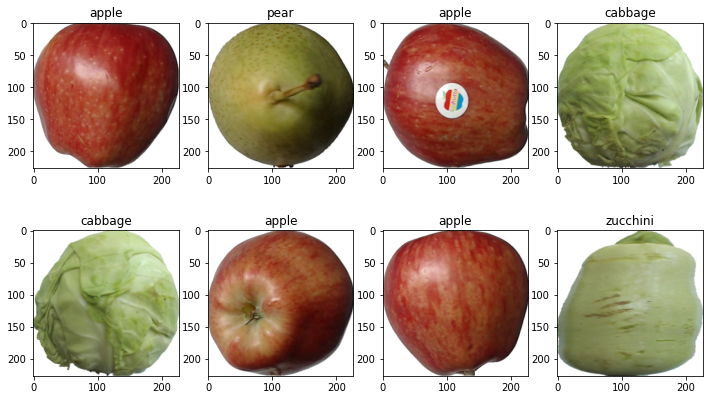

In [87]:
#Plotting few images from dataset
plt.figure(figsize = (12,7))
for i in range(8):
  ind = random.randint(0, len(X_train))
  plt.subplot(240 + 1 + i)
  plt.imshow(X_train[ind])
  plt.title(data_folder[np.argmax(y_train[ind])])

### Train Model

In [99]:
def alexnet_model(model, X_train, y_train, X_test, y_test, epochs, batch_size, callbacks):
  # Data generator
  #datagen = ImageDataGenerator(rotation_range = 5, width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)
  datagen = ImageDataGenerator(rescale=1./255, rotation_range= 40, width_shift_range= 0.2, height_shift_range= 0.2,shear_range= 0.2,zoom_range= 0.2, horizontal_flip= True, fill_mode= 'nearest')
  # iteration on the training set
  it_train = datagen.flow(X_train, y_train, batch_size = batch_size)
  # path to save checkpoint 
  path_cp = os.getcwd() + '/' + 'weights_.hdf5'
  checkpoint_ = ModelCheckpoint(path_cp, monitor = 'loss', save_best_only = True, mode = 'auto')
  steps = X_train.shape[0]//batch_size
  # Fitting the model
  history = model.fit(it_train, steps_per_epoch = steps, epochs=epochs, verbose=1, callbacks=[callbacks], validation_data=(X_test, y_test))
  # Evaluating the model
  _, acc = model.evaluate(X_test, y_test, verbose = 1)
  print('%.3f' % (acc * 100.0))  
  return history, acc

In [100]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    # Check accuracy
    if(logs.get('accuracy') > 0.95):
      # Stop if threshold is met
      print("\n Accuracy is higher than 0.95 so cancelling training!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

In [ ]:
train_history, acc = alexnet_model(Alexnet_model, X_train, y_train, X_test, y_test, epochs = 100, batch_size = 128, callbacks = callbacks)

In [90]:
#saving the trained model 
Alexnet_model.save('model.h5')

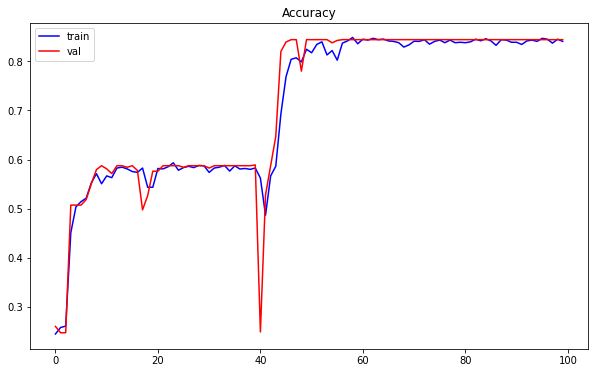

In [91]:
#function to plot the accuracy
def accuracy_plot(history):
  plt.figure(figsize = (10,6))
  plt.plot(history.history['accuracy'], color = 'blue', label = 'train')
  plt.plot(history.history['val_accuracy'], color = 'red', label = 'val')
  plt.legend()
  plt.title('Accuracy')
  plt.show()

#calling the plot function for plotting accuracy
accuracy_plot(train_history)

###Prediction


In [98]:
#initialize an empty array
y_pred = []
for i in np.arange(len(X_test)):
  img = X_test[i]
  print(img.shape)
  # reshaping the image size
  img = img.reshape (1, 227, 227, 3)
  #initializing the model prediction object
  yp = Alexnet_model.predict(img)
  #appending it to the array object
  y_pred.append(yp)
  """#initialize final prediction object
  final_predicted_val = data_folder[np.argmax(y_pred)]
  #plotting the predicted image 
  plt.subplot(240+1+i)
  plt.imshow(img)
  plt.title('predicted: ' + str(final_predicted_val))"""

y_test_pred = np.asarray(y_pred)
print(y_test_pred)


(227, 227, 3)
1/1 [==============================] - 0s 42ms/step
(227, 227, 3)
1/1 [==============================] - 0s 42ms/step
(227, 227, 3)
1/1 [==============================] - 0s 47ms/step
(227, 227, 3)
1/1 [==============================] - 0s 40ms/step
(227, 227, 3)
1/1 [==============================] - 0s 42ms/step
(227, 227, 3)
1/1 [==============================] - 0s 42ms/step
(227, 227, 3)
1/1 [==============================] - 0s 41ms/step
(227, 227, 3)
1/1 [==============================] - 0s 42ms/step
(227, 227, 3)
1/1 [==============================] - 0s 42ms/step
(227, 227, 3)
1/1 [==============================] - 0s 41ms/step
(227, 227, 3)
1/1 [==============================] - 0s 47ms/step
(227, 227, 3)
1/1 [==============================] - 0s 42ms/step
(227, 227, 3)
1/1 [==============================] - 0s 48ms/step
(227, 227, 3)
1/1 [==============================] - 0s 41ms/step
(227, 227, 3)
1/1 [==============================] - 0s 41ms/step
(227, 227,